In [ ]:
import numpy as np
from moonlight import *
import matplotlib.pyplot as plt

import pandas as pd


In [ ]:
data_path = "melbourne_bikes_11_17.csv"
df = pd.read_csv(data_path)
df

,ID,NAME,TERMINALNAME,NBBIKES,NBEMPTYDOCKS,RUNDATE,INSTALLED,TEMPORARY,LOCKED,LASTCOMMWITHSERVER,LATESTUPDATETIME,REMOVALDATE,INSTALLDATE,LAT,LONG,LOCATION
0,2,Harbour Town - Docklands Dve - Docklands,60000,10,11,20170422134506,True,False,False,1492832566010,1.492833e+12,NaN,1.313725e+12,-37.814022,144.939521,"(-37.814022, 144.939521)"
1,4,Federation Square - Flinders St / Swanston St ...,60001,9,18,20170422134506,True,False,False,1492832631727,1.492832e+12,NaN,NaN,-37.817523,144.967814,"(-37.817523, 144.967814)"
2,6,State Library - Swanston St / Little Lonsdale ...,60003,1,10,20170422134506,True,False,False,1492832015231,1.492832e+12,NaN,NaN,-37.810702,144.964417,"(-37.810702, 144.964417)"
3,7,Bourke Street Mall - 205 Bourke St - City,60004,4,7,20170422134506,True,False,False,1492832218661,1.492830e+12,NaN,NaN,-37.813088,144.967437,"(-37.813088, 144.967437)"
4,8,Melbourne Uni - Tin Alley - Carlton,60005,8,11,20170422134506,True,False,False,1492832103674,1.492769e+12,NaN,NaN,-37.796250,144.960858,"(-37.79625, 144.960858)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5644549,11,MSAC - Aughtie Dve - Albert Park,60008,25,2,20180901054506,True,False,False,1507119158324,1.507107e+12,NaN,NaN,-37.842395,144.961868,"(-37.842395, 144.961868)"
5644550,12,Fitzroy Town Hall - Moor St - Fitzroy,60009,10,1,20180901054506,True,False,False,1507119316227,1.507104e+12,NaN,NaN,-37.801813,144.979209,"(-37.801813, 144.979209)"
5644551,14,Plum Garland Reserve - Beaconsfield Pde - Albe...,60010,19,0,20180901054506,True,False,False,1507119388674,1.507105e+12,NaN,1.277175e+12,-37.847795,144.948351,"(-37.847795, 144.948351)"
5644552,15,Coventry St / St Kilda Rd - Southbank,60017,5,6,20180901054506,True,False,False,1507118899768,1.507116e+12,NaN,1.277175e+12,-37.828887,144.970822,"(-37.828887, 144.970822)"


In [3]:
def extract_seconds(int_date: int):
    date = str(int_date)
    hour = int(date[8:10])
    minutes = int(date[10:12])
    seconds = int(date[12:])
    return seconds + minutes * 60 + hour * 3600

In [4]:
specific_date = "20170422" # April 22nd, 2017
df_day = df[df["RUNDATE"].apply(lambda date: str(date).startswith(specific_date))]
df_day.head(1)
df_day["ABS_TIME"] = df_day["RUNDATE"].apply(lambda date: extract_seconds(date))

/var/folders/p7/3_3g7g_x7t9dc251z7lwpqqm0000gn/T/ipykernel_20509/1361014306.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_day["ABS_TIME"] = df_day["RUNDATE"].apply(lambda date: extract_seconds(date))


In [5]:
df_day["ABS_TIME"]

0         49506
1         49506
2         49506
3         49506
4         49506
          ...  
816834    50406
816835    50406
816836    50406
816837    50406
816838    50406
Name: ABS_TIME, Length: 4800, dtype: int64

In [6]:
def extract_from_df(df: pd.DataFrame, name: str):
    location = df[df["NAME"] == name]
    row = location.iloc[0]
    coordinates = row["LAT"], row["LONG"]
    traces = location.apply(lambda row: row["NBBIKES"], axis = 1)
    values = traces.values
    times = row["ABS_TIME"]
    return (coordinates, values, times)
    

coords, values, times = extract_from_df(df_day, "Harbour Town - Docklands Dve - Docklands")
# values

In [7]:
names = df_day["NAME"].unique()

In [8]:
def show_locations_map(coords: [(float, float)]):
    for lat,long in coords:
        plt.scatter(lat, long)
    # plt.show()

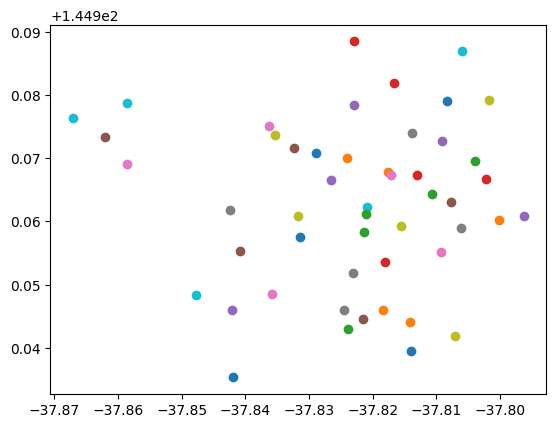

In [9]:
for name in names:
    coords, values, times = extract_from_df(df_day, name)
    show_locations_map([coords])

In [16]:
from location import LocationDatabase
locationDb = LocationDatabase()
locationDb.generate_from_df(df_day)
graph = locationDb.generate_graph()

In [11]:
script = """
signal { int nBikes; }
space { edges { real distance; } }
domain minmax;
formula good_service = everywhere(distance) [0, 500] (nBikes > 10);
"""
specification = ScriptLoader.loadFromText(script)
monitor = specification.getMonitor("good_service")
result = monitor.monitor([0.0], graph, locationDb.get_time(), locationDb.get_traces())
# result

times = new double[]{0.0}
graph = new double[][][]{{{0.0, 0.0, 0.0}, {0.0, 1.0, 2521.3715003231723}, {0.0, 2.0, 2222.9916041062584}, {0.0, 3.0, 2460.3106915413946}, {0.0, 4.0, 2724.290640286659}, {0.0, 5.0, 2191.2934350988753}, {0.0, 6.0, 2480.624075549464}, {0.0, 7.0, 3713.2252534260874}, {0.0, 8.0, 3748.4829238796083}, {0.0, 9.0, 3828.3255545393704}, {0.0, 10.0, 3212.0357492611615}, {0.0, 11.0, 737.466605915492}, {0.0, 12.0, 1129.4520568674675}, {0.0, 13.0, 2738.6930751828813}, {0.0, 14.0, 2978.210623072924}, {0.0, 15.0, 3289.4485912349896}, {0.0, 16.0, 2544.0552973176054}, {0.0, 17.0, 1293.4583933931779}, {0.0, 18.0, 803.7595851240637}, {0.0, 19.0, 2140.741518361856}, {0.0, 20.0, 3122.4959941021907}, {0.0, 21.0, 401.6635475771852}, {0.0, 22.0, 2055.8627624573273}, {0.0, 23.0, 1319.0685126977273}, {0.0, 24.0, 3177.124923834529}, {0.0, 25.0, 6102.304177770968}, {0.0, 26.0, 5586.5715867686085}, {0.0, 27.0, 1487.3041607738523}, {0.0, 28.0, 1747.43153785643}, {0.0, 29.0, 4270.71297663428

lat -37.867068 -37.79625
long 144.935296 144.988507


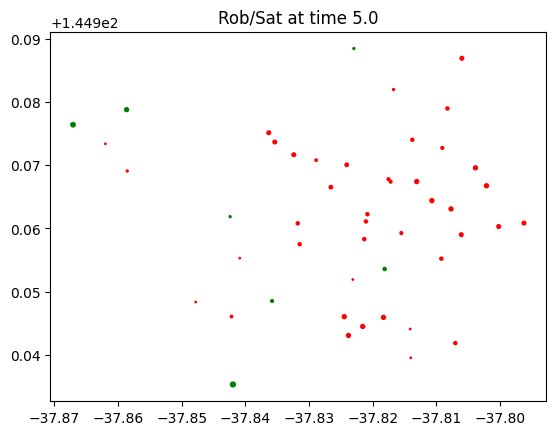

In [14]:
locationDb.plot_results(result, 0)